<a href="https://colab.research.google.com/github/Tongwu18/fu-yao/blob/main/Halle_1_RL_0912.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from typing import List, Tuple, Optional, Dict, Any
from dataclasses import dataclass, field
import copy

df = pd.read_excel("https://github.com/Tongwu18/fu-yao/raw/main/111.xlsx")
df

,玻璃索引,最短宽,高2,Count of 玻璃索引
0,1,112.0,35.0,28
1,2,112.0,35.0,13
2,3,180.0,102.0,30
3,4,180.0,102.0,15
4,5,180.0,102.0,8
...,...,...,...,...
696,697,115.0,79.5,1
697,698,114.0,63.0,1
698,699,209.0,64.0,1
699,700,143.0,64.0,15


# 环境


In [7]:
"""
玻璃货架装箱 V9
可配置参数 + 超参数分析
"""

import numpy as np
import pandas as pd
import time
from collections import Counter
import matplotlib.pyplot as plt


# 默认常量 (mm)
SHELF_W = 360.0
SHELF_H = 800.0
SEP = 27.0
GAP = 9.0
MAX_STACK1 = 4
MAX_STACK2 = 2


class Packer:
    def __init__(self, df, min_layers=3, min_layer_h=35.0):
        """
        参数:
            df: 数据
            min_layers: 最少层数 (默认3)
            min_layer_h: 每层最低高度mm (默认35)
        """
        self.min_layers = min_layers
        self.min_layer_h = min_layer_h
        self.df = df

        id_col = next((c for c in ['玻璃索引', 'glass_id', 'id'] if c in df.columns), None)
        w_col = next((c for c in ['最短宽', 'width'] if c in df.columns), None)
        h_col = next((c for c in ['高2', 'height'] if c in df.columns), None)
        cnt_col = next((c for c in ['Count of 玻璃索引', 'count'] if c in df.columns), None)

        self.ids = df[id_col].values.astype(int) if id_col else np.arange(len(df))
        self.W = df[w_col].values.astype(float)
        self.H = df[h_col].values.astype(float)
        self.C = df[cnt_col].values.astype(int)
        self.n = len(self.W)
        self.total_boxes = self.C.sum()

        total_area_m2 = np.sum(self.W * self.H * self.C) / 1e6
        self.theoretical_min = int(np.ceil(total_area_m2 / (SHELF_W * SHELF_H / 1e6)))

        self.best_order = None

    def _calc_shelf_height(self, shelf):
        n_layers = len(shelf)
        layer_heights = sum(l[0] for l in shelf)
        sep_heights = max(0, n_layers - 1) * SEP
        return layer_heights + sep_heights

    def _get_min_remaining_height(self, shelf):
        n_layers = len(shelf)
        if n_layers >= self.min_layers:
            return 0
        need_layers = self.min_layers - n_layers
        return need_layers * self.min_layer_h + need_layers * SEP

    def _can_fit_with_min_layers(self, shelf, delta=0):
        current_h = self._calc_shelf_height(shelf) + delta
        min_remaining = self._get_min_remaining_height(shelf)
        return current_h + min_remaining <= SHELF_H

    def pack(self, order):
        remaining = self.C.copy()
        shelves = [[[0.0, []]]]

        for idx in order:
            gw, gh = self.W[idx], self.H[idx]

            while remaining[idx] > 0:
                placed = False

                for shelf in shelves:
                    # 1. 尝试叠放
                    for li, layer in enumerate(shelf):
                        lh, positions = layer[0], layer[1]
                        for pi, (gidx, stk) in enumerate(positions):
                            if gidx == idx:
                                max_stk = MAX_STACK1 if li == 0 else MAX_STACK2
                                if stk < max_stk:
                                    new_h = gh * (stk + 1)
                                    test_lh = max(lh, new_h)
                                    delta = test_lh - lh

                                    old_val = shelf[li][0]
                                    shelf[li][0] = test_lh
                                    can_fit = self._can_fit_with_min_layers(shelf)
                                    shelf[li][0] = old_val

                                    if can_fit:
                                        positions[pi] = (gidx, stk + 1)
                                        shelf[li][0] = test_lh
                                        remaining[idx] -= 1
                                        placed = True
                                        break
                        if placed:
                            break
                    if placed:
                        break

                    # 2. 现有层新位置
                    for li, layer in enumerate(shelf):
                        lh, positions = layer[0], layer[1]
                        used_w = sum(self.W[g] for g, _ in positions)
                        if len(positions) > 0:
                            used_w += GAP * len(positions)

                        if used_w + gw <= SHELF_W:
                            test_lh = max(lh, gh)

                            old_val = shelf[li][0]
                            shelf[li][0] = test_lh
                            can_fit = self._can_fit_with_min_layers(shelf)
                            shelf[li][0] = old_val

                            if can_fit:
                                positions.append((idx, 1))
                                shelf[li][0] = test_lh
                                remaining[idx] -= 1
                                placed = True
                                break
                    if placed:
                        break

                    # 3. 新层
                    current_h = self._calc_shelf_height(shelf)
                    new_h_with_layer = current_h + SEP + gh
                    n_layers_after = len(shelf) + 1

                    if n_layers_after < self.min_layers:
                        need_more = self.min_layers - n_layers_after
                        min_extra = need_more * (self.min_layer_h + SEP)
                        if new_h_with_layer + min_extra <= SHELF_H:
                            shelf.append([gh, [(idx, 1)]])
                            remaining[idx] -= 1
                            placed = True
                            break
                    else:
                        if new_h_with_layer <= SHELF_H:
                            shelf.append([gh, [(idx, 1)]])
                            remaining[idx] -= 1
                            placed = True
                            break

                # 4. 新货架
                if not placed:
                    new_shelf = [[gh, [(idx, 1)]]]
                    shelves.append(new_shelf)
                    remaining[idx] -= 1

        # 补足到min_layers层
        for shelf in shelves:
            while len(shelf) < self.min_layers:
                current_h = self._calc_shelf_height(shelf)
                if current_h + SEP + self.min_layer_h <= SHELF_H:
                    shelf.append([self.min_layer_h, []])
                else:
                    break

        return len(shelves)

    def pack_full(self, order):
        remaining = self.C.copy()
        shelves = [[[0.0, []]]]

        for idx in order:
            gw, gh = self.W[idx], self.H[idx]

            while remaining[idx] > 0:
                placed = False

                for shelf in shelves:
                    for li, layer in enumerate(shelf):
                        lh, positions = layer[0], layer[1]
                        for pi, (gidx, stk) in enumerate(positions):
                            if gidx == idx:
                                max_stk = MAX_STACK1 if li == 0 else MAX_STACK2
                                if stk < max_stk:
                                    new_h = gh * (stk + 1)
                                    test_lh = max(lh, new_h)

                                    old_val = shelf[li][0]
                                    shelf[li][0] = test_lh
                                    can_fit = self._can_fit_with_min_layers(shelf)
                                    shelf[li][0] = old_val

                                    if can_fit:
                                        positions[pi] = (gidx, stk + 1)
                                        shelf[li][0] = test_lh
                                        remaining[idx] -= 1
                                        placed = True
                                        break
                        if placed:
                            break
                    if placed:
                        break

                    for li, layer in enumerate(shelf):
                        lh, positions = layer[0], layer[1]
                        used_w = sum(self.W[g] for g, _ in positions)
                        if len(positions) > 0:
                            used_w += GAP * len(positions)

                        if used_w + gw <= SHELF_W:
                            test_lh = max(lh, gh)

                            old_val = shelf[li][0]
                            shelf[li][0] = test_lh
                            can_fit = self._can_fit_with_min_layers(shelf)
                            shelf[li][0] = old_val

                            if can_fit:
                                positions.append((idx, 1))
                                shelf[li][0] = test_lh
                                remaining[idx] -= 1
                                placed = True
                                break
                    if placed:
                        break

                    current_h = self._calc_shelf_height(shelf)
                    new_h_with_layer = current_h + SEP + gh
                    n_layers_after = len(shelf) + 1

                    if n_layers_after < self.min_layers:
                        need_more = self.min_layers - n_layers_after
                        min_extra = need_more * (self.min_layer_h + SEP)
                        if new_h_with_layer + min_extra <= SHELF_H:
                            shelf.append([gh, [(idx, 1)]])
                            remaining[idx] -= 1
                            placed = True
                            break
                    else:
                        if new_h_with_layer <= SHELF_H:
                            shelf.append([gh, [(idx, 1)]])
                            remaining[idx] -= 1
                            placed = True
                            break

                if not placed:
                    new_shelf = [[gh, [(idx, 1)]]]
                    shelves.append(new_shelf)
                    remaining[idx] -= 1

        for shelf in shelves:
            while len(shelf) < self.min_layers:
                current_h = self._calc_shelf_height(shelf)
                if current_h + SEP + self.min_layer_h <= SHELF_H:
                    shelf.append([self.min_layer_h, []])
                else:
                    break

        return shelves

    def get_orders(self):
        orders = {}
        orders['area_desc'] = np.argsort(-(self.W * self.H))
        orders['height_desc'] = np.argsort(-self.H)
        orders['width_desc'] = np.argsort(-self.W)
        orders['volume_desc'] = np.argsort(-(self.W * self.H * self.C))
        orders['h_w_desc'] = np.lexsort((-self.W, -self.H))
        orders['height_asc'] = np.argsort(self.H)

        h_order = []
        for h in sorted(set(self.H), reverse=True):
            idxs = list(np.where(self.H == h)[0])
            idxs.sort(key=lambda i: -self.W[i] * self.C[i])
            h_order.extend(idxs)
        orders['h_group_wc'] = np.array(h_order)

        return orders

    def local_search(self, order, max_iter=5000, max_time=60):
        n = len(order)
        current = list(order)
        current_cost = self.pack(current)
        best, best_cost = current.copy(), current_cost

        start = time.time()
        no_improve, temp = 0, 2.0

        for _ in range(max_iter):
            if time.time() - start > max_time or no_improve > 800:
                break

            new = current.copy()
            r = np.random.random()
            if r < 0.5:
                i, j = np.random.randint(0, n, 2)
                new[i], new[j] = new[j], new[i]
            elif r < 0.8:
                i, j = np.random.randint(n), np.random.randint(n)
                v = new.pop(i)
                new.insert(j, v)
            else:
                i, j = sorted(np.random.randint(0, n, 2))
                new[i:j+1] = new[i:j+1][::-1]

            new_cost = self.pack(new)
            delta = new_cost - current_cost

            if delta < 0 or (temp > 0.01 and np.random.random() < np.exp(-delta / temp)):
                current, current_cost = new, new_cost
                if current_cost < best_cost:
                    best, best_cost = current.copy(), current_cost
                    no_improve = 0
                else:
                    no_improve += 1
            else:
                no_improve += 1
            temp *= 0.997

        return best, best_cost

    def statistics(self, order):
        shelves = self.pack_full(order)
        layer_counts = Counter(len(shelf) for shelf in shelves)

        total_used = 0
        total_boxes = 0
        empty_layers = 0
        for shelf in shelves:
            for lh, positions in shelf:
                if len(positions) == 0:
                    empty_layers += 1
                for idx, stk in positions:
                    total_used += self.W[idx] * self.H[idx] * stk
                    total_boxes += stk

        total_layers = sum(len(s) for s in shelves)
        util = total_used / (len(shelves) * SHELF_W * SHELF_H)

        print("\n" + "=" * 50)
        print("货架统计")
        print("=" * 50)
        print(f"总货架数: {len(shelves)}")
        print(f"总箱数: {total_boxes}")
        print(f"平均利用率: {util*100:.1f}%")
        print(f"总层数: {total_layers} | 空层: {empty_layers}")
        print()
        print("按层数分类:")
        print("-" * 30)
        for n_layers in sorted(layer_counts.keys()):
            count = layer_counts[n_layers]
            pct = count / len(shelves) * 100
            print(f"  {n_layers}层货架: {count:4d} 个 ({pct:5.1f}%)")
        print("-" * 30)

        return shelves, layer_counts

    def export_plan(self, order, filename="装箱方案.xlsx"):
        shelves = self.pack_full(order)

        rows = []
        for si, shelf in enumerate(shelves):
            shelf_h = self._calc_shelf_height(shelf)
            shelf_boxes = sum(stk for _, positions in shelf for _, stk in positions)
            shelf_used = sum(self.W[idx] * self.H[idx] * stk
                           for _, positions in shelf for idx, stk in positions)
            shelf_util = shelf_used / (SHELF_W * SHELF_H) * 100

            for li, (lh, positions) in enumerate(shelf):
                layer_w = sum(self.W[idx] for idx, _ in positions)
                if len(positions) > 1:
                    layer_w += GAP * (len(positions) - 1)
                layer_boxes = sum(stk for _, stk in positions)

                if len(positions) == 0:
                    rows.append({
                        '货架号': si + 1,
                        '货架层数': len(shelf),
                        '货架总高mm': round(shelf_h, 1),
                        '货架利用率%': round(shelf_util, 1),
                        '货架箱数': shelf_boxes,
                        '层号': li + 1,
                        '层高mm': round(lh, 1),
                        '层已用宽mm': 0,
                        '层箱数': 0,
                        '位置号': '-',
                        '玻璃ID': '(空)',
                        '玻璃宽mm': '-',
                        '玻璃高mm': '-',
                        '叠放数': 0
                    })
                else:
                    for pi, (idx, stk) in enumerate(positions):
                        rows.append({
                            '货架号': si + 1,
                            '货架层数': len(shelf),
                            '货架总高mm': round(shelf_h, 1),
                            '货架利用率%': round(shelf_util, 1),
                            '货架箱数': shelf_boxes,
                            '层号': li + 1,
                            '层高mm': round(lh, 1),
                            '层已用宽mm': round(layer_w, 1),
                            '层箱数': layer_boxes,
                            '位置号': pi + 1,
                            '玻璃ID': self.ids[idx],
                            '玻璃宽mm': self.W[idx],
                            '玻璃高mm': self.H[idx],
                            '叠放数': stk
                        })

        df_out = pd.DataFrame(rows)
        df_out.to_excel(filename, index=False)
        print(f"\n已导出: {filename} ({len(rows)} 条记录)")

        return df_out


def analyze_hyperparams(df, show_plot=True):
    """
    分析超参数对结果的影响，绘制Elbow图
    """
    print("=" * 50)
    print("超参数分析 (Elbow Plot)")
    print("=" * 50)

    # 获取基准排序
    id_col = next((c for c in ['玻璃索引', 'glass_id', 'id'] if c in df.columns), None)
    w_col = next((c for c in ['最短宽', 'width'] if c in df.columns), None)
    h_col = next((c for c in ['高2', 'height'] if c in df.columns), None)

    W = df[w_col].values.astype(float)
    H = df[h_col].values.astype(float)
    base_order = list(np.argsort(-(W * H)))  # area_desc

    results = {}

    # 1. 分析 min_layers
    print("\n1. 最少层数 (min_layers) 影响:")
    min_layers_range = [1, 2, 3, 4, 5]
    min_layers_results = []
    for ml in min_layers_range:
        packer = Packer(df, min_layers=ml, min_layer_h=35)
        n_shelves = packer.pack(base_order)
        min_layers_results.append(n_shelves)
        print(f"  min_layers={ml}: {n_shelves} 货架")
    results['min_layers'] = (min_layers_range, min_layers_results)

    # 2. 分析 min_layer_h
    print("\n2. 最低层高 (min_layer_h) 影响:")
    min_h_range = [20, 35, 50, 75, 100, 125, 150]
    min_h_results = []
    for mh in min_h_range:
        packer = Packer(df, min_layers=3, min_layer_h=mh)
        n_shelves = packer.pack(base_order)
        min_h_results.append(n_shelves)
        print(f"  min_layer_h={mh}mm: {n_shelves} 货架")
    results['min_layer_h'] = (min_h_range, min_h_results)

    # 3. 绘制Elbow图
    if show_plot:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # min_layers elbow
        ax1 = axes[0]
        ax1.plot(min_layers_range, min_layers_results, 'bo-', linewidth=2, markersize=8)
        ax1.set_xlabel('min_layers (最少层数)', fontsize=12)
        ax1.set_ylabel('货架数', fontsize=12)
        ax1.set_title('最少层数 vs 货架数', fontsize=14)
        ax1.grid(True, alpha=0.3)

        # 标记最优点
        best_idx = np.argmin(min_layers_results)
        ax1.scatter([min_layers_range[best_idx]], [min_layers_results[best_idx]],
                   color='red', s=150, zorder=5, label=f'最优: {min_layers_range[best_idx]}层={min_layers_results[best_idx]}架')
        ax1.legend()

        # min_layer_h elbow
        ax2 = axes[1]
        ax2.plot(min_h_range, min_h_results, 'go-', linewidth=2, markersize=8)
        ax2.set_xlabel('min_layer_h (最低层高 mm)', fontsize=12)
        ax2.set_ylabel('货架数', fontsize=12)
        ax2.set_title('最低层高 vs 货架数', fontsize=14)
        ax2.grid(True, alpha=0.3)

        # 标记拐点
        # 计算二阶导数找拐点
        diffs = np.diff(min_h_results)
        diff2 = np.diff(diffs)
        if len(diff2) > 0:
            elbow_idx = np.argmax(diff2) + 1
            ax2.axvline(x=min_h_range[elbow_idx], color='red', linestyle='--', alpha=0.7)
            ax2.scatter([min_h_range[elbow_idx]], [min_h_results[elbow_idx]],
                       color='red', s=150, zorder=5, label=f'拐点: {min_h_range[elbow_idx]}mm={min_h_results[elbow_idx]}架')
        ax2.legend()

        plt.tight_layout()
        plt.savefig('elbow_plot.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("\n图表已保存: elbow_plot.png")

    return results


def train(df, max_time=280, min_layers=3, min_layer_h=35, analyze=False):
    """
    训练

    参数:
        df: 数据
        max_time: 最大时间(秒)
        min_layers: 最少层数
        min_layer_h: 每层最低高度(mm)
        analyze: 是否先进行超参数分析
    """
    start = time.time()

    # 超参数分析
    if analyze:
        analyze_hyperparams(df, show_plot=True)
        print("\n" + "=" * 50)
        print("开始正式训练")
        print("=" * 50)

    packer = Packer(df, min_layers=min_layers, min_layer_h=min_layer_h)

    print(f"\n玻璃种类: {packer.n} | 总箱数: {packer.total_boxes}")
    print(f"约束: 最少{min_layers}层, 每层最低{min_layer_h}mm")
    print("=" * 50)

    print("阶段1: 排序策略...")
    orders = packer.get_orders()
    results = [(packer.pack(list(o)), n, list(o)) for n, o in orders.items()]
    for cost, name, _ in sorted(results):
        print(f"  {name}: {cost}")

    results.sort()
    best_cost, best_name, best_order = results[0]
    print(f"最佳: {best_name} = {best_cost} | 耗时: {time.time()-start:.1f}s")

    remain = max_time - (time.time() - start)
    if remain > 30:
        print(f"\n阶段2: 局部搜索...")
        search_time = min(remain - 10, 150) / 3
        for i in range(min(3, len(results))):
            cost, name, order = results[i]
            new_order, new_cost = packer.local_search(order, max_iter=8000, max_time=search_time)
            print(f"  {name}: {cost} -> {new_cost}")
            if new_cost < best_cost:
                best_cost, best_order = new_cost, new_order

    packer.best_order = best_order
    shelves, layer_counts = packer.statistics(best_order)

    print(f"\nvs VBA(799): {best_cost - 799:+d}")
    print(f"总耗时: {time.time()-start:.1f}s")

    return packer


def export(packer, filename="装箱方案.xlsx"):
    if packer.best_order is None:
        print("请先运行 train()")
        return
    return packer.export_plan(packer.best_order, filename)

#  超参数分析


In [3]:
# analyze_hyperparams(df)

# 训练


In [9]:
packer = train(df, min_layer_h=50)
export(packer, "装箱方案.xlsx")


玻璃种类: 701 | 总箱数: 12117
约束: 最少3层, 每层最低50mm
阶段1: 排序策略...
  area_desc: 765
  h_group_wc: 769
  width_desc: 769
  volume_desc: 770
  h_w_desc: 772
  height_desc: 774
  height_asc: 812
最佳: area_desc = 765 | 耗时: 209.9s

阶段2: 局部搜索...
  area_desc: 765 -> 765
  h_group_wc: 769 -> 769
  width_desc: 769 -> 769

货架统计
总货架数: 765
总箱数: 12117
平均利用率: 77.6%
总层数: 2580 | 空层: 2

按层数分类:
------------------------------
  3层货架:  533 个 ( 69.7%)
  4层货架:  194 个 ( 25.4%)
  5层货架:   26 个 (  3.4%)
  6层货架:   10 个 (  1.3%)
  7层货架:    1 个 (  0.1%)
  8层货架:    1 个 (  0.1%)
------------------------------

vs VBA(799): -34
总耗时: 426.5s

已导出: 装箱方案.xlsx (5827 条记录)


,货架号,货架层数,货架总高mm,货架利用率%,货架箱数,层号,层高mm,层已用宽mm,层箱数,位置号,玻璃ID,玻璃宽mm,玻璃高mm,叠放数
0,1,3,788.0,72.4,11,1,644.0,331.0,7,1,85,161.0,161.0,3
1,1,3,788.0,72.4,11,1,644.0,331.0,7,2,79,161.0,161.0,4
2,1,3,788.0,72.4,11,2,45.0,309.6,2,1,342,150.3,45.0,1
3,1,3,788.0,72.4,11,2,45.0,309.6,2,2,342,150.3,45.0,1
4,1,3,788.0,72.4,11,3,45.0,309.6,2,1,342,150.3,45.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5822,765,3,301.0,7.5,6,1,147.0,244.0,6,1,385,76.0,49.0,3
5823,765,3,301.0,7.5,6,1,147.0,244.0,6,2,370,75.0,46.0,1
5824,765,3,301.0,7.5,6,1,147.0,244.0,6,3,371,75.0,46.0,2
5825,765,3,301.0,7.5,6,2,50.0,0.0,0,-,(空),-,-,0


In [10]:
"""
Layer Pattern Clustering Analysis
Goal: Find standard shelf configurations (layer height combinations)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")


def extract_layer_patterns(df_result, max_layers=6):
    """
    从装箱结果提取每个货架的层高模式
    """
    shelves = df_result.groupby('货架号')

    patterns = []
    shelf_ids = []

    for shelf_id, group in shelves:
        # 获取每层高度（去重，按层号排序）
        layers = group.groupby('层号')['层高mm'].first().sort_index()
        layer_heights = tuple(layers.values)

        patterns.append(layer_heights)
        shelf_ids.append(shelf_id)

    print("=" * 60)
    print("Layer Pattern Extraction")
    print("=" * 60)
    print(f"Total shelves: {len(patterns)}")

    # 统计层数分布
    layer_counts = Counter(len(p) for p in patterns)
    print(f"\nLayer count distribution:")
    for n_layers, count in sorted(layer_counts.items()):
        print(f"  {n_layers} layers: {count} shelves ({count/len(patterns)*100:.1f}%)")

    # 统计独特模式数
    unique_patterns = Counter(patterns)
    print(f"\nUnique patterns: {len(unique_patterns)}")
    print(f"Top 10 most common patterns:")
    for pattern, count in unique_patterns.most_common(10):
        pattern_str = " + ".join([f"{h:.0f}" for h in pattern])
        print(f"  [{len(pattern)}L] {pattern_str}mm : {count} shelves")

    # 转换为矩阵（填充0）
    pattern_matrix = np.zeros((len(patterns), max_layers))
    for i, p in enumerate(patterns):
        for j, h in enumerate(p):
            if j < max_layers:
                pattern_matrix[i, j] = h

    return patterns, pattern_matrix, shelf_ids, unique_patterns


def analyze_patterns_simple(df_result):
    """
    简单分析：直接统计层高组合模式
    """
    patterns, _, _, unique_patterns = extract_layer_patterns(df_result)

    # 按层数分组统计
    by_n_layers = {}
    for pattern, count in unique_patterns.items():
        n = len(pattern)
        if n not in by_n_layers:
            by_n_layers[n] = []
        by_n_layers[n].append((pattern, count))

    print("\n" + "=" * 60)
    print("Patterns Grouped by Layer Count")
    print("=" * 60)

    for n_layers in sorted(by_n_layers.keys()):
        print(f"\n【{n_layers} Layers】")
        patterns_list = sorted(by_n_layers[n_layers], key=lambda x: -x[1])
        for pattern, count in patterns_list[:5]:  # Top 5
            pattern_str = " + ".join([f"{h:.0f}" for h in pattern])
            pct = count / len(patterns) * 100
            print(f"  {pattern_str}mm : {count} ({pct:.1f}%)")
        if len(patterns_list) > 5:
            print(f"  ... and {len(patterns_list)-5} more patterns")

    return by_n_layers


def recommend_standard_configs(df_result, n_configs=5):
    """
    推荐标准货架配置
    """
    patterns, _, _, unique_patterns = extract_layer_patterns(df_result)

    # 按频率排序
    sorted_patterns = unique_patterns.most_common()

    print("\n" + "=" * 60)
    print(f"Recommended {n_configs} Standard Configurations")
    print("=" * 60)

    # 覆盖率计算
    total = len(patterns)
    covered = 0
    recommendations = []

    for i, (pattern, count) in enumerate(sorted_patterns[:n_configs]):
        covered += count
        coverage = covered / total * 100

        pattern_str = " + ".join([f"{h:.0f}" for h in pattern])
        total_h = sum(pattern) + (len(pattern)-1) * 27  # 加上分隔板

        rec = {
            'rank': i + 1,
            'layers': len(pattern),
            'heights': pattern,
            'total_height': total_h,
            'count': count,
            'coverage': coverage
        }
        recommendations.append(rec)

        print(f"\nConfig {i+1}: 【{len(pattern)} layers】")
        print(f"  Layer heights: {pattern_str}mm")
        print(f"  Total height: {total_h:.0f}mm (with separators)")
        print(f"  Count: {count} shelves")
        print(f"  Cumulative coverage: {coverage:.1f}%")

    return recommendations


def plot_pattern_analysis(df_result, n_clusters=5):
    """
    可视化层高模式分析
    """
    patterns, pattern_matrix, _, unique_patterns = extract_layer_patterns(df_result)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. 层数分布
    ax1 = axes[0, 0]
    layer_counts = [len(p) for p in patterns]
    sns.countplot(x=layer_counts, ax=ax1, palette='viridis')
    ax1.set_xlabel('Number of Layers', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_title('Distribution of Layer Count', fontsize=14, fontweight='bold')

    for p in ax1.patches:
        ax1.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom', fontsize=10)

    # 2. 各层高度分布（箱线图）
    ax2 = axes[0, 1]
    layer_data = []
    for i in range(6):
        heights = [p[i] for p in patterns if len(p) > i]
        if heights:
            layer_data.extend([(f'Layer {i+1}', h) for h in heights])

    df_layers = pd.DataFrame(layer_data, columns=['Layer', 'Height'])
    sns.boxplot(data=df_layers, x='Layer', y='Height', ax=ax2, palette='Set2')
    ax2.set_xlabel('Layer', fontsize=12)
    ax2.set_ylabel('Height (mm)', fontsize=12)
    ax2.set_title('Height Distribution by Layer', fontsize=14, fontweight='bold')

    # 3. Top 10 模式频率
    ax3 = axes[1, 0]
    top_patterns = unique_patterns.most_common(10)
    pattern_labels = [f"{len(p)}L: {'+'.join([str(int(h)) for h in p])}" for p, _ in top_patterns]
    pattern_counts = [c for _, c in top_patterns]

    colors = sns.color_palette('husl', 10)
    bars = ax3.barh(range(len(pattern_labels)), pattern_counts, color=colors)
    ax3.set_yticks(range(len(pattern_labels)))
    ax3.set_yticklabels(pattern_labels, fontsize=9)
    ax3.set_xlabel('Count', fontsize=12)
    ax3.set_title('Top 10 Layer Patterns', fontsize=14, fontweight='bold')
    ax3.invert_yaxis()

    for bar, count in zip(bars, pattern_counts):
        ax3.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{count}', va='center', fontsize=9)

    # 4. 累计覆盖率
    ax4 = axes[1, 1]
    sorted_counts = sorted(unique_patterns.values(), reverse=True)
    cumsum = np.cumsum(sorted_counts) / len(patterns) * 100

    ax4.plot(range(1, len(cumsum)+1), cumsum, 'b-', linewidth=2)
    ax4.fill_between(range(1, len(cumsum)+1), cumsum, alpha=0.3)

    # 标记关键点
    for target in [50, 80, 90, 95]:
        idx = np.searchsorted(cumsum, target)
        if idx < len(cumsum):
            ax4.axhline(y=target, color='gray', linestyle='--', alpha=0.5)
            ax4.axvline(x=idx+1, color='gray', linestyle='--', alpha=0.5)
            ax4.scatter([idx+1], [target], color='red', s=50, zorder=5)
            ax4.annotate(f'{idx+1} patterns\n={target}%',
                        xy=(idx+1, target), xytext=(idx+20, target-5),
                        fontsize=9, ha='left')

    ax4.set_xlabel('Number of Standard Patterns', fontsize=12)
    ax4.set_ylabel('Coverage (%)', fontsize=12)
    ax4.set_title('Cumulative Coverage by Pattern Count', fontsize=14, fontweight='bold')
    ax4.set_xlim(0, min(50, len(cumsum)))
    ax4.set_ylim(0, 105)

    plt.tight_layout()
    plt.savefig('layer_pattern_analysis.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.show()
    print("\nPlot saved: layer_pattern_analysis.png")


def full_analysis(df_result):
    """
    完整的层高模式分析
    """
    # 1. 简单统计
    by_n_layers = analyze_patterns_simple(df_result)

    # 2. 推荐标准配置
    recommendations = recommend_standard_configs(df_result, n_configs=8)

    # 3. 可视化
    plot_pattern_analysis(df_result)

    return {
        'by_n_layers': by_n_layers,
        'recommendations': recommendations
    }


if __name__ == "__main__":
    print("Usage:")
    print("  from layer_clustering import full_analysis")
    print("  results = full_analysis(df_result)")

Usage:
  from layer_clustering import full_analysis
  results = full_analysis(df_result)


# 结果分析


In [6]:
results = full_analysis(df_result)

NameError: name 'df_result' is not defined

# 探索最优组合

Glass Height Distribution Analysis
Total boxes: 12117
Height range: 35 - 161 mm
Height mean: 95.7 mm
Height std: 23.9 mm

Height percentiles:
  10%: 67mm
  25%: 74mm
  50%: 110mm
  75%: 117mm
  90%: 124mm
  95%: 124mm
  99%: 125mm


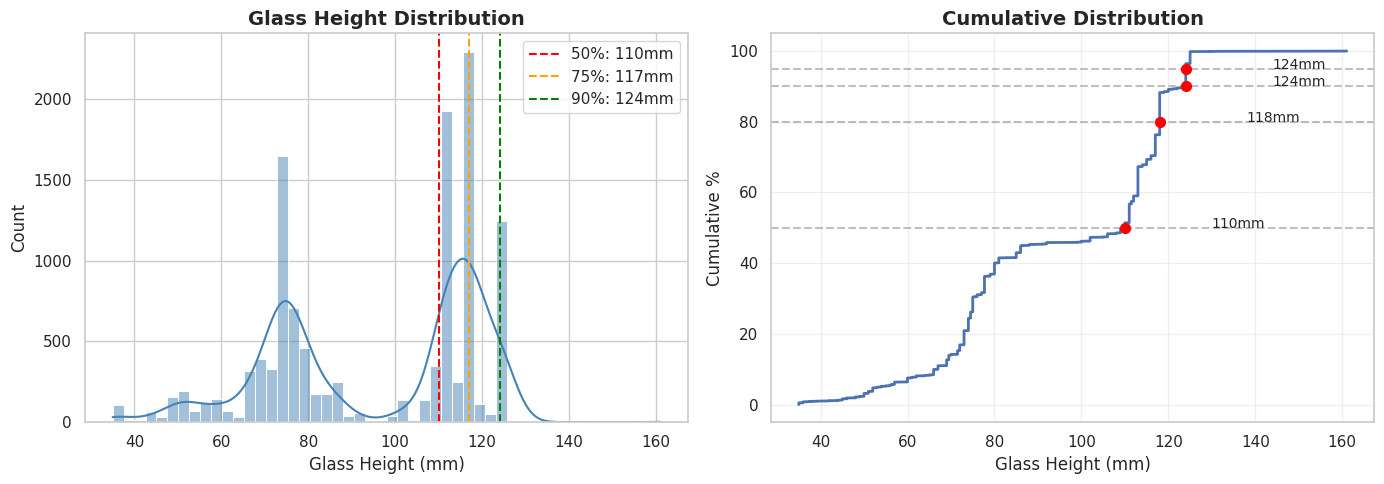

In [3]:
"""
玻璃高度分布分析
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")

SHELF_H = 800.0
SEP = 27.0


def analyze_glass(df):
    """
    分析玻璃高度分布
    """
    w_col = next((c for c in ['最短宽', 'width'] if c in df.columns), None)
    h_col = next((c for c in ['高2', 'height'] if c in df.columns), None)
    cnt_col = next((c for c in ['Count of 玻璃索引', 'count'] if c in df.columns), None)

    W = df[w_col].values.astype(float)
    H = df[h_col].values.astype(float)
    C = df[cnt_col].values.astype(int)

    # 展开成每个箱子
    all_heights = []
    all_widths = []
    for w, h, c in zip(W, H, C):
        all_heights.extend([h] * c)
        all_widths.extend([w] * c)

    all_heights = np.array(all_heights)
    all_widths = np.array(all_widths)

    # 打印统计信息
    print("=" * 60)
    print("Glass Height Distribution Analysis")
    print("=" * 60)
    print(f"Total boxes: {len(all_heights)}")
    print(f"Height range: {all_heights.min():.0f} - {all_heights.max():.0f} mm")
    print(f"Height mean: {all_heights.mean():.1f} mm")
    print(f"Height std: {all_heights.std():.1f} mm")

    # 分位数
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    print(f"\nHeight percentiles:")
    for p in percentiles:
        val = np.percentile(all_heights, p)
        print(f"  {p}%: {val:.0f}mm")

    # 绘图
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # 图1: 高度分布直方图
    ax1 = axes[0]
    sns.histplot(all_heights, bins=50, kde=True, ax=ax1, color='steelblue')
    ax1.set_xlabel('Glass Height (mm)', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_title('Glass Height Distribution', fontsize=14, fontweight='bold')

    for p, color in [(50, 'red'), (75, 'orange'), (90, 'green')]:
        val = np.percentile(all_heights, p)
        ax1.axvline(val, color=color, linestyle='--', label=f'{p}%: {val:.0f}mm')
    ax1.legend()

    # 图2: 累计分布
    ax2 = axes[1]
    sorted_h = np.sort(all_heights)
    cumsum = np.arange(1, len(sorted_h)+1) / len(sorted_h) * 100
    ax2.plot(sorted_h, cumsum, linewidth=2)
    ax2.set_xlabel('Glass Height (mm)', fontsize=12)
    ax2.set_ylabel('Cumulative %', fontsize=12)
    ax2.set_title('Cumulative Distribution', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    for target in [50, 80, 90, 95]:
        idx = np.searchsorted(cumsum, target)
        if idx < len(sorted_h):
            ax2.axhline(target, color='gray', linestyle='--', alpha=0.5)
            ax2.scatter([sorted_h[idx]], [target], color='red', s=50, zorder=5)
            ax2.annotate(f'{sorted_h[idx]:.0f}mm', xy=(sorted_h[idx], target),
                        xytext=(sorted_h[idx]+20, target), fontsize=10)

    plt.tight_layout()
    plt.savefig('glass_height_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

    return {
        'heights': all_heights,
        'widths': all_widths,
        'H': H,
        'W': W,
        'C': C
    }
results = analyze_glass(df)

## 遗传算法

In [14]:
"""
改进版层高分析与拼接优化
核心：最大化每层的空间利用率
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter, defaultdict
from itertools import combinations_with_replacement
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")

SHELF_W = 360.0
SHELF_H = 800.0
SEP = 27.0
GAP = 9.0
MAX_STACK1 = 4  # 第一层最大叠放
MAX_STACK2 = 2  # 其他层最大叠放


class LayerOptimizer:
    def __init__(self, df_result):
        """
        从装箱结果初始化

        参数:
            df_result: export()导出的装箱方案
        """
        self.df = df_result
        self._parse_data()

    def _parse_data(self):
        """解析装箱数据"""
        # 提取每层信息
        df = self.df[self.df['叠放数'] > 0].copy()

        # 按货架-层分组
        layer_groups = df.groupby(['货架号', '层号'])

        self.layers = []
        for (shelf_id, layer_id), group in layer_groups:
            layer_h = group['层高mm'].iloc[0]
            # 计算该层的实际使用高度（考虑叠放）
            # 每个位置的实际高度 = 玻璃高 * 叠放数 / 叠放数 = 玻璃高（叠放后的总高）
            positions = []
            for _, row in group.iterrows():
                glass_h = row['玻璃高mm']
                stack = row['叠放数']
                # 叠放后的高度 = 玻璃高 * 叠放数（假设同种玻璃叠放）
                # 实际上叠放后高度应该从数据中获取，这里用层高作为上限
                stack_h = glass_h * stack  # 近似
                positions.append({
                    'glass_h': glass_h,
                    'stack': stack,
                    'stack_h': min(stack_h, layer_h)  # 不超过层高
                })

            # 该层的最大堆叠高度
            max_stack_h = max(p['stack_h'] for p in positions) if positions else 0

            self.layers.append({
                'shelf_id': shelf_id,
                'layer_id': layer_id,
                'layer_h': layer_h,
                'used_h': max_stack_h,
                'util': max_stack_h / layer_h if layer_h > 0 else 0,
                'positions': positions
            })

        print(f"解析完成: {len(self.layers)}层")

    def analyze_utilization(self):
        """分析层利用率"""
        print("\n" + "=" * 60)
        print("层利用率分析")
        print("=" * 60)

        layer_heights = [l['layer_h'] for l in self.layers]
        utilizations = [l['util'] for l in self.layers]
        used_heights = [l['used_h'] for l in self.layers]

        print(f"\n总层数: {len(self.layers)}")
        print(f"平均层利用率: {np.mean(utilizations)*100:.1f}%")
        print(f"层高范围: {min(layer_heights):.0f} - {max(layer_heights):.0f}mm")
        print(f"实际使用高度范围: {min(used_heights):.0f} - {max(used_heights):.0f}mm")

        # 按层高分组统计利用率
        height_util = defaultdict(list)
        for l in self.layers:
            h = round(l['layer_h'])
            height_util[h].append(l['util'])

        print("\n各层高的平均利用率:")
        print("-" * 50)
        for h in sorted(height_util.keys(), reverse=True)[:15]:
            utils = height_util[h]
            avg_util = np.mean(utils) * 100
            count = len(utils)
            print(f"  {h:4.0f}mm: {count:4d}层, 平均利用率 {avg_util:5.1f}%")

        return layer_heights, used_heights, utilizations

    def cluster_by_used_height(self, k_range=(4, 10)):
        """
        关键改进：按实际使用高度聚类，而非层高
        这样能找到真正需要的层高
        """
        print("\n" + "=" * 60)
        print("按实际使用高度聚类")
        print("=" * 60)

        used_heights = np.array([l['used_h'] for l in self.layers])
        X = used_heights.reshape(-1, 1)

        k_values = list(range(k_range[0], k_range[1] + 1))
        results = []

        print("\n聚类分析:")
        for k in k_values:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X)
            sil = silhouette_score(X, labels)

            # 每个聚类的最大使用高度 → 这就是需要的层高
            cluster_info = []
            for i in range(k):
                mask = labels == i
                cluster_used = used_heights[mask]
                max_used = cluster_used.max()
                # 标准层高 = 最大使用高度 + 余量，向上取整到10
                std_h = int(np.ceil((max_used + 5) / 10) * 10)
                cluster_info.append({
                    'max_used': max_used,
                    'std_h': std_h,
                    'count': mask.sum(),
                    'mean_used': cluster_used.mean()
                })

            cluster_info.sort(key=lambda x: -x['std_h'])
            std_heights = [c['std_h'] for c in cluster_info]

            results.append({
                'k': k,
                'sil': sil,
                'cluster_info': cluster_info,
                'std_heights': std_heights
            })

            heights_str = ", ".join([str(h) for h in std_heights])
            print(f"  K={k}: Sil={sil:.3f}, 层高=[{heights_str}]")

        # 选择最优K
        best = max(results, key=lambda x: x['sil'])
        print(f"\n最优K={best['k']} (Silhouette={best['sil']:.3f})")

        print("\n推荐的标准层高:")
        print("-" * 60)
        total_layers = sum(c['count'] for c in best['cluster_info'])
        for i, c in enumerate(best['cluster_info']):
            pct = c['count'] / total_layers * 100
            print(f"  {c['std_h']:4d}mm: {c['count']:4d}层 ({pct:5.1f}%), 最大使用={c['max_used']:.0f}mm, 平均={c['mean_used']:.0f}mm")

        self.std_heights = best['std_heights']
        self.cluster_info = best['cluster_info']

        return best

    def plot_analysis(self, used_heights, best_result):
        """绘制分析图"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # 1. 实际使用高度分布
        ax1 = axes[0, 0]
        sns.histplot(used_heights, bins=50, kde=True, ax=ax1, color='steelblue')
        ax1.set_xlabel('Actual Used Height (mm)', fontsize=12)
        ax1.set_ylabel('Count', fontsize=12)
        ax1.set_title('Distribution of Actually Used Height', fontsize=14, fontweight='bold')

        # 标记标准层高
        colors = plt.cm.Set1(np.linspace(0, 1, len(self.std_heights)))
        for h, color in zip(self.std_heights, colors):
            ax1.axvline(h, color=color, linestyle='--', linewidth=2, label=f'Std: {h}mm')
        ax1.legend()

        # 2. 层高 vs 利用率
        ax2 = axes[0, 1]
        layer_h = [l['layer_h'] for l in self.layers]
        util = [l['util'] * 100 for l in self.layers]
        ax2.scatter(layer_h, util, alpha=0.3, s=10)
        ax2.set_xlabel('Layer Height (mm)', fontsize=12)
        ax2.set_ylabel('Utilization (%)', fontsize=12)
        ax2.set_title('Layer Height vs Utilization', fontsize=14, fontweight='bold')
        ax2.axhline(80, color='red', linestyle='--', label='80% target')
        ax2.legend()

        # 3. 聚类结果
        ax3 = axes[1, 0]
        k = best_result['k']
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(np.array(used_heights).reshape(-1, 1))

        palette = sns.color_palette("husl", k)
        for i, c in enumerate(best_result['cluster_info']):
            mask = labels == i
            cluster_h = np.array(used_heights)[mask]
            ax3.hist(cluster_h, bins=30, alpha=0.6, color=palette[i],
                    label=f"Std {c['std_h']}mm: {c['count']}层")
        ax3.set_xlabel('Used Height (mm)', fontsize=12)
        ax3.set_ylabel('Count', fontsize=12)
        ax3.set_title(f'Clustering Result (K={k})', fontsize=14, fontweight='bold')
        ax3.legend()

        # 4. 标准层高数量分布
        ax4 = axes[1, 1]
        std_h = [c['std_h'] for c in best_result['cluster_info']]
        counts = [c['count'] for c in best_result['cluster_info']]
        colors = sns.color_palette("viridis", len(std_h))
        bars = ax4.bar([str(h) for h in std_h], counts, color=colors)
        ax4.set_xlabel('Standard Layer Height (mm)', fontsize=12)
        ax4.set_ylabel('Count', fontsize=12)
        ax4.set_title('Layer Count by Standard Height', fontsize=14, fontweight='bold')

        for bar, count in zip(bars, counts):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                    str(count), ha='center', fontsize=10)

        plt.tight_layout()
        plt.savefig('layer_optimization_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
        plt.show()
        print("\n图表已保存: layer_optimization_analysis.png")

    def optimize_assembly(self, method='dp'):
        """
        优化层拼接成货架

        method: 'greedy' | 'dp' | 'ilp'
        """
        print("\n" + "=" * 60)
        print("层拼接优化")
        print("=" * 60)

        layer_counts = {c['std_h']: c['count'] for c in self.cluster_info}

        print("\n输入:")
        total = 0
        for h in sorted(layer_counts.keys(), reverse=True):
            cnt = layer_counts[h]
            total += cnt
            print(f"  {h}mm: {cnt}层")
        print(f"  总计: {total}层")

        if method == 'dp':
            shelves = self._dp_assembly(layer_counts)
        else:
            shelves = self._greedy_assembly(layer_counts)

        # 统计结果
        self._analyze_assembly_result(shelves)

        return shelves

    def _greedy_assembly(self, layer_counts):
        """贪心拼接"""
        # 生成所有可行配置
        heights = list(layer_counts.keys())
        valid_configs = []

        for n in range(2, 6):
            capacity = SHELF_H - (n - 1) * SEP
            for combo in combinations_with_replacement(heights, n):
                if sum(combo) <= capacity:
                    config = tuple(sorted(combo, reverse=True))
                    total_h = sum(config) + (n - 1) * SEP
                    util = sum(config) / SHELF_H
                    valid_configs.append((config, util, total_h))

        # 去重，按利用率排序
        valid_configs = list(set(valid_configs))
        valid_configs.sort(key=lambda x: -x[1])

        print(f"\n可行配置: {len(valid_configs)}种")
        print("Top 5 高利用率:")
        for cfg, util, total in valid_configs[:5]:
            s = "+".join([str(h) for h in cfg])
            print(f"  [{s}]: {total:.0f}mm, {util*100:.1f}%")

        # 贪心选择
        remaining = dict(layer_counts)
        shelves = []

        while sum(remaining.values()) > 0:
            best_config = None

            for config, util, total in valid_configs:
                needed = Counter(config)
                if all(remaining.get(h, 0) >= needed[h] for h in needed):
                    best_config = config
                    break

            if best_config:
                shelves.append(best_config)
                for h in best_config:
                    remaining[h] -= 1
            else:
                # 处理剩余
                for h in sorted(remaining.keys(), reverse=True):
                    while remaining[h] > 0:
                        shelves.append((h,))
                        remaining[h] -= 1
                break

        return shelves

    def _dp_assembly(self, layer_counts):
        """
        动态规划 + 贪心混合
        先用高利用率配置，再处理剩余
        """
        heights = sorted(layer_counts.keys(), reverse=True)

        # 生成高利用率配置（利用率>90%）
        good_configs = []
        for n in range(2, 6):
            capacity = SHELF_H - (n - 1) * SEP
            for combo in combinations_with_replacement(heights, n):
                if sum(combo) <= capacity:
                    config = tuple(sorted(combo, reverse=True))
                    util = sum(config) / SHELF_H
                    if util >= 0.90:  # 只保留高利用率配置
                        total_h = sum(config) + (n - 1) * SEP
                        good_configs.append((config, util, total_h))

        good_configs = list({c[0]: c for c in good_configs}.values())
        good_configs.sort(key=lambda x: -x[1])

        print(f"\n高利用率配置 (≥90%): {len(good_configs)}种")
        for cfg, util, total in good_configs[:8]:
            s = "+".join([str(h) for h in cfg])
            print(f"  [{s}]: {total:.0f}mm, {util*100:.1f}%")

        # 优先使用高利用率配置
        remaining = dict(layer_counts)
        shelves = []

        changed = True
        while changed and sum(remaining.values()) > 0:
            changed = False
            for config, util, total in good_configs:
                needed = Counter(config)
                while all(remaining.get(h, 0) >= needed[h] for h in needed):
                    shelves.append(config)
                    for h in config:
                        remaining[h] -= 1
                    changed = True

        # 处理剩余（用FFD）
        leftover = []
        for h, cnt in remaining.items():
            leftover.extend([h] * cnt)
        leftover.sort(reverse=True)

        if leftover:
            print(f"\n剩余层: {len(leftover)}个, 用FFD处理")
            ffd_shelves = []
            for layer_h in leftover:
                placed = False
                for shelf in ffd_shelves:
                    current_h = sum(shelf) + (len(shelf) - 1) * SEP
                    new_h = current_h + layer_h + SEP
                    if new_h <= SHELF_H:
                        shelf.append(layer_h)
                        placed = True
                        break
                if not placed:
                    ffd_shelves.append([layer_h])

            shelves.extend([tuple(sorted(s, reverse=True)) for s in ffd_shelves])

        return shelves

    def _analyze_assembly_result(self, shelves):
        """分析拼接结果"""
        config_counts = Counter(shelves)

        print(f"\n拼接结果: {len(shelves)}个货架, {len(config_counts)}种配置")
        print("-" * 60)

        results = []
        for config, count in config_counts.most_common(15):
            total_h = sum(config) + (len(config) - 1) * SEP
            util = sum(config) / SHELF_H * 100
            s = " + ".join([str(h) for h in config])
            pct = count / len(shelves) * 100
            results.append({
                'config': config,
                'count': count,
                'util': util
            })
            print(f"  [{len(config)}层] {s}mm ({total_h:.0f}mm, {util:.0f}%): {count}个 ({pct:.1f}%)")

        if len(config_counts) > 15:
            print(f"  ... 还有 {len(config_counts) - 15} 种")

        print("-" * 60)
        avg_util = np.mean([sum(s) / SHELF_H for s in shelves]) * 100
        print(f"  总计: {len(shelves)} 货架, 平均利用率: {avg_util:.1f}%")

        # 输出配置代码
        print(f"\n可用于 train() 的配置:")
        print("configs = [")
        for r in results[:8]:
            print(f"    {r['config']},  # {r['count']}个, {r['util']:.0f}%")
        print("]")

        self.assembly_result = results
        return results


def full_analysis(df_result, k_range=(4, 10)):
    """
    完整分析流程

    用法:
        from layer_optimizer_v2 import full_analysis
        optimizer, shelves = full_analysis(df_result)
    """
    optimizer = LayerOptimizer(df_result)

    # 1. 利用率分析
    layer_h, used_h, util = optimizer.analyze_utilization()

    # 2. 按使用高度聚类
    best = optimizer.cluster_by_used_height(k_range)

    # 3. 绘图
    optimizer.plot_analysis(used_h, best)

    # 4. 优化拼接
    shelves = optimizer.optimize_assembly(method='dp')

    return optimizer, shelves


if __name__ == "__main__":
    print("用法:")
    print("  from layer_optimizer_v2 import full_analysis")
    print("  optimizer, shelves = full_analysis(df_result)")

用法:
  from layer_optimizer_v2 import full_analysis
  optimizer, shelves = full_analysis(df_result)



已导出: 装箱方案.xlsx (5827 条记录)
解析完成: 2578层

层利用率分析

总层数: 2578
平均层利用率: 100.0%
层高范围: 35 - 644mm
实际使用高度范围: 35 - 644mm

各层高的平均利用率:
--------------------------------------------------
   644mm:    1层, 平均利用率 100.0%
   500mm:   42层, 平均利用率 100.0%
   496mm:   69层, 平均利用率 100.0%
   488mm:    3层, 平均利用率 100.0%
   484mm:    1层, 平均利用率 100.0%
   480mm:    4层, 平均利用率 100.0%
   472mm:  121层, 平均利用率 100.0%
   468mm:   60层, 平均利用率 100.0%
   464mm:    9层, 平均利用率 100.0%
   460mm:   16层, 平均利用率 100.0%
   456mm:    1层, 平均利用率 100.0%
   452mm:   84层, 平均利用率 100.0%
   448mm:   10层, 平均利用率 100.0%
   446mm:    6层, 平均利用率 100.0%
   444mm:   45层, 平均利用率 100.0%

按实际使用高度聚类

聚类分析:
  K=4: Sil=0.702, 层高=[650, 360, 200, 110]
  K=5: Sil=0.726, 层高=[650, 380, 270, 190, 110]
  K=6: Sil=0.767, 层高=[650, 380, 270, 190, 140, 100]
  K=7: Sil=0.720, 层高=[650, 470, 380, 270, 190, 140, 100]
  K=8: Sil=0.712, 层高=[650, 470, 380, 320, 260, 190, 140, 100]
  K=9: Sil=0.740, 层高=[650, 490, 470, 380, 320, 260, 190, 140, 100]
  K=10: Sil=0.734, 层高=[650, 490

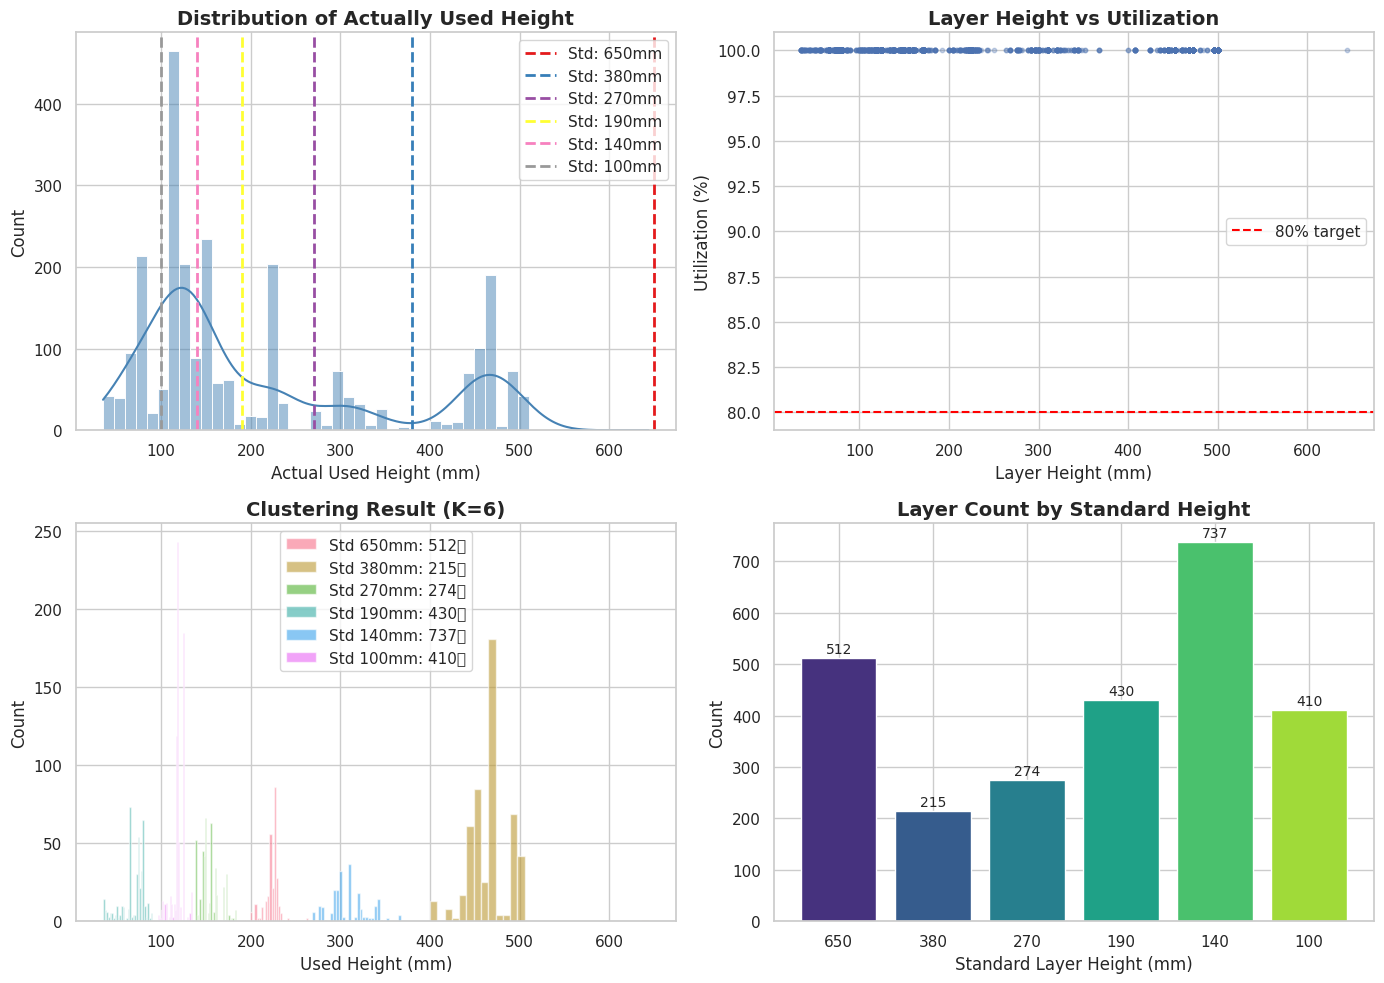


图表已保存: layer_optimization_analysis.png

层拼接优化

输入:
  650mm: 512层
  380mm: 215层
  270mm: 274层
  190mm: 430层
  140mm: 737层
  100mm: 410层
  总计: 2578层

高利用率配置 (≥90%): 3种
  [380+380]: 787mm, 95.0%
  [650+100]: 777mm, 93.8%
  [270+270+190]: 784mm, 91.2%

剩余层: 1133个, 用FFD处理

拼接结果: 1014个货架, 8种配置
------------------------------------------------------------
  [2层] 650 + 100mm (777mm, 94%): 410个 (40.4%)
  [4层] 140 + 140 + 140 + 140mm (641mm, 70%): 159个 (15.7%)
  [3层] 270 + 270 + 190mm (784mm, 91%): 137个 (13.5%)
  [2层] 380 + 380mm (787mm, 95%): 107个 (10.6%)
  [1层] 650mm (650mm, 81%): 102个 (10.1%)
  [4层] 190 + 190 + 190 + 140mm (791mm, 89%): 97个 (9.6%)
  [3层] 380 + 190 + 140mm (764mm, 89%): 1个 (0.1%)
  [4层] 190 + 140 + 140 + 140mm (691mm, 76%): 1个 (0.1%)
------------------------------------------------------------
  总计: 1014 货架, 平均利用率: 88.1%

可用于 train() 的配置:
configs = [
    (650, 100),  # 410个, 94%
    (140, 140, 140, 140),  # 159个, 70%
    (270, 270, 190),  # 137个, 91%
    (380, 380),  # 107个, 9

In [15]:
df_result = export(packer, "装箱方案.xlsx")
standard_heights = full_analysis(df_result)

## 贪心算法


In [13]:
"""
层拼接优化器
将标准层高拼接成货架，最小化货架数

算法：First Fit Decreasing (FFD) + 贪心优化
"""

import numpy as np
from collections import Counter, defaultdict
from itertools import combinations_with_replacement, permutations
import time


SHELF_H = 800.0
SEP = 27.0


def calculate_shelf_capacity(n_layers):
    """n层货架的可用高度"""
    return SHELF_H - (n_layers - 1) * SEP


def ffd_packing(layer_heights, layer_counts):
    """
    First Fit Decreasing 算法

    参数:
        layer_heights: 层高列表 [650, 270, 190, 140, 90]
        layer_counts: 每种层高的数量 {650: 512, 270: 274, ...}

    返回:
        shelves: 货架列表，每个元素是层高元组
    """
    # 展开成层列表，按高度降序
    layers = []
    for h in layer_heights:
        layers.extend([h] * layer_counts.get(h, 0))
    layers.sort(reverse=True)

    # FFD: 每个层放入第一个能装下的货架
    shelves = []  # [(remaining_h, [layer_heights])]

    for layer_h in layers:
        placed = False

        for shelf in shelves:
            remaining_h, shelf_layers = shelf
            # 需要高度 = 层高 + 分隔板（如果不是第一层）
            needed = layer_h + (SEP if shelf_layers else 0)

            if needed <= remaining_h:
                shelf_layers.append(layer_h)
                shelf[0] = remaining_h - needed
                placed = True
                break

        if not placed:
            shelves.append([SHELF_H - layer_h, [layer_h]])

    return [tuple(sorted(s[1], reverse=True)) for s in shelves]


def analyze_shelf_configs(shelves):
    """分析货架配置分布"""
    config_counts = Counter(shelves)

    print(f"\n货架配置统计 ({len(shelves)}个货架, {len(config_counts)}种配置):")
    print("-" * 60)

    results = []
    for i, (config, count) in enumerate(config_counts.most_common()):
        total_h = sum(config) + (len(config) - 1) * SEP
        util = sum(config) / SHELF_H * 100
        layers_str = " + ".join([str(int(h)) for h in config])
        pct = count / len(shelves) * 100

        results.append({
            'config': config,
            'count': count,
            'total_h': total_h,
            'util': util,
            'pct': pct
        })

        if i < 15:
            print(f"  [{len(config)}层] {layers_str}mm ({total_h:.0f}mm, {util:.0f}%): {count:4d}个 ({pct:.1f}%)")

    if len(config_counts) > 15:
        print(f"  ... 还有 {len(config_counts) - 15} 种配置")

    print("-" * 60)
    print(f"  总计: {len(shelves)} 货架")

    return results


def optimize_with_patterns(layer_heights, layer_counts, max_configs=8):
    """
    模式优化：枚举所有可能的货架配置，选择最优组合

    适用于层种类少（<10种）的情况
    """
    print(f"\n{'='*60}")
    print("模式优化：寻找最优货架配置组合")
    print(f"{'='*60}")

    # 生成所有可行的货架配置
    valid_configs = []

    for n_layers in range(2, 7):  # 2-6层
        capacity = calculate_shelf_capacity(n_layers)

        # 枚举所有组合
        for combo in combinations_with_replacement(layer_heights, n_layers):
            if sum(combo) <= capacity:
                # 规范化（降序排列）
                config = tuple(sorted(combo, reverse=True))
                total_h = sum(config) + (n_layers - 1) * SEP
                util = sum(config) / SHELF_H * 100
                valid_configs.append({
                    'config': config,
                    'total_h': total_h,
                    'util': util
                })

    # 去重
    seen = set()
    unique_configs = []
    for c in valid_configs:
        if c['config'] not in seen:
            seen.add(c['config'])
            unique_configs.append(c)

    # 按利用率排序
    unique_configs.sort(key=lambda x: -x['util'])

    print(f"生成 {len(unique_configs)} 种可行货架配置")
    print("\nTop 10 高利用率配置:")
    for i, c in enumerate(unique_configs[:10]):
        layers_str = "+".join([str(int(h)) for h in c['config']])
        print(f"  [{layers_str}]: {c['total_h']:.0f}mm, 利用率{c['util']:.1f}%")

    # 贪心选择配置组合
    print(f"\n贪心选择最优配置组合...")

    remaining = dict(layer_counts)  # 剩余层数
    selected_shelves = []

    while sum(remaining.values()) > 0:
        best_config = None
        best_score = -1

        # 找能用的最优配置
        for cfg_info in unique_configs:
            config = cfg_info['config']

            # 检查是否有足够的层
            needed = Counter(config)
            can_use = all(remaining.get(h, 0) >= needed[h] for h in needed)

            if can_use:
                # 评分 = 利用率
                score = cfg_info['util']
                if score > best_score:
                    best_score = score
                    best_config = config

        if best_config:
            selected_shelves.append(best_config)
            for h in best_config:
                remaining[h] -= 1
        else:
            # 没有完美配置，用FFD处理剩余
            leftover = []
            for h, cnt in remaining.items():
                leftover.extend([h] * cnt)
            if leftover:
                leftover.sort(reverse=True)
                for h in leftover:
                    # 尝试放入已有货架
                    placed = False
                    for i, shelf in enumerate(selected_shelves):
                        total = sum(shelf) + (len(shelf) - 1) * SEP
                        new_total = total + h + SEP
                        if new_total <= SHELF_H:
                            selected_shelves[i] = tuple(sorted(list(shelf) + [h], reverse=True))
                            placed = True
                            break
                    if not placed:
                        selected_shelves.append((h,))
            break

    return selected_shelves


def ilp_packing(layer_heights, layer_counts):
    """
    整数线性规划 (ILP) 求精确最优解
    需要安装: pip install pulp
    """
    try:
        from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, PULP_CBC_CMD
    except ImportError:
        print("需要安装pulp: pip install pulp")
        return None

    print(f"\n{'='*60}")
    print("整数线性规划 (ILP) 求解")
    print(f"{'='*60}")

    # 生成所有可行配置
    configs = []
    for n_layers in range(2, 7):
        capacity = calculate_shelf_capacity(n_layers)
        for combo in combinations_with_replacement(layer_heights, n_layers):
            if sum(combo) <= capacity:
                config = tuple(sorted(combo, reverse=True))
                if config not in configs:
                    configs.append(config)

    print(f"可行配置数: {len(configs)}")

    # 创建问题
    prob = LpProblem("ShelfPacking", LpMinimize)

    # 变量: 每种配置使用多少个
    x = {i: LpVariable(f"x_{i}", lowBound=0, cat='Integer') for i in range(len(configs))}

    # 目标: 最小化货架总数
    prob += lpSum(x[i] for i in range(len(configs)))

    # 约束: 每种层高的数量必须满足
    for h in layer_heights:
        cnt_needed = layer_counts.get(h, 0)
        # 每个配置贡献的h层数量
        prob += lpSum(x[i] * configs[i].count(h) for i in range(len(configs))) >= cnt_needed

    # 求解
    prob.solve(PULP_CBC_CMD(msg=0))

    if LpStatus[prob.status] == 'Optimal':
        total_shelves = int(sum(x[i].varValue for i in range(len(configs))))
        print(f"最优解: {total_shelves} 货架")

        # 构建结果
        shelves = []
        for i in range(len(configs)):
            cnt = int(x[i].varValue) if x[i].varValue else 0
            if cnt > 0:
                shelves.extend([configs[i]] * cnt)

        return shelves
    else:
        print(f"求解失败: {LpStatus[prob.status]}")
        return None


def full_optimize(layer_heights, layer_counts, method='pattern'):
    """
    完整优化流程

    参数:
        layer_heights: 层高列表
        layer_counts: 每种层高数量字典
        method: 'ffd' | 'pattern' | 'ilp'
    """
    print(f"{'='*60}")
    print("层拼接优化")
    print(f"{'='*60}")

    print(f"\n输入:")
    total_layers = 0
    for h in sorted(layer_heights, reverse=True):
        cnt = layer_counts.get(h, 0)
        total_layers += cnt
        print(f"  {h}mm: {cnt}层")
    print(f"  总计: {total_layers}层")

    start = time.time()

    if method == 'ffd':
        shelves = ffd_packing(layer_heights, layer_counts)
    elif method == 'pattern':
        shelves = optimize_with_patterns(layer_heights, layer_counts)
    elif method == 'ilp':
        shelves = ilp_packing(layer_heights, layer_counts)
        if shelves is None:
            print("ILP失败，使用FFD")
            shelves = ffd_packing(layer_heights, layer_counts)
    else:
        shelves = ffd_packing(layer_heights, layer_counts)

    print(f"\n耗时: {time.time()-start:.2f}s")

    # 分析结果
    results = analyze_shelf_configs(shelves)

    # 输出配置代码
    print(f"\n{'='*60}")
    print("可用于 train() 的配置 (Top 8):")
    print("configs = [")
    for r in results[:8]:
        print(f"    {r['config']},  # {r['count']}个, 利用率{r['util']:.0f}%")
    print("]")

    return results, shelves


# 便捷函数
def optimize_from_analysis(standard_heights, layer_counts_list):
    """
    从聚类分析结果直接优化

    用法:
        # 聚类分析得到:
        # 标准层高: [650, 270, 190, 140, 90]
        # 数量: [512, 274, 430, 737, 412]

        results, shelves = optimize_from_analysis(
            [650, 270, 190, 140, 90],
            [512, 274, 430, 737, 412]
        )
    """
    layer_counts = dict(zip(standard_heights, layer_counts_list))
    return full_optimize(standard_heights, layer_counts, method='pattern')
results, shelves = optimize_from_analysis(
    [650, 370, 270, 190, 140, 90],   # 6种标准层高
    [512, 215, 274, 430, 737, 412]   # 对应数量
)

层拼接优化

输入:
  650mm: 512层
  370mm: 215层
  270mm: 274层
  190mm: 430层
  140mm: 737层
  90mm: 412层
  总计: 2580层

模式优化：寻找最优货架配置组合
生成 78 种可行货架配置

Top 10 高利用率配置:
  [650+90]: 767mm, 利用率92.5%
  [370+370]: 767mm, 利用率92.5%
  [370+270+90]: 784mm, 利用率91.2%
  [270+270+190]: 784mm, 利用率91.2%
  [190+190+190+140]: 791mm, 利用率88.8%
  [370+190+140]: 754mm, 利用率87.5%
  [370+140+90+90]: 771mm, 利用率86.2%
  [270+190+140+90]: 771mm, 利用率86.2%
  [270+140+140+140]: 771mm, 利用率86.2%
  [270+270+140]: 734mm, 利用率85.0%

贪心选择最优配置组合...

耗时: 0.45s

货架配置统计 (1014个货架, 8种配置):
------------------------------------------------------------
  [2层] 650 + 90mm (767mm, 92%):  412个 (40.6%)
  [4层] 140 + 140 + 140 + 140mm (641mm, 70%):  159个 (15.7%)
  [3层] 270 + 270 + 190mm (784mm, 91%):  137个 (13.5%)
  [2层] 370 + 370mm (767mm, 92%):  107个 (10.6%)
  [1层] 650mm (650mm, 81%):  100个 (9.9%)
  [4层] 190 + 190 + 190 + 140mm (791mm, 89%):   97个 (9.6%)
  [3层] 370 + 190 + 140mm (754mm, 88%):    1个 (0.1%)
  [4层] 190 + 140 + 140 + 140mm (691mm, 76%):   

# 用新的组合训练

In [17]:
"""
玻璃货架装箱 V10
约束: 只能使用标准货架配置，不能定制
"""

import numpy as np
import pandas as pd
import time
from collections import Counter


# 常量 (mm)
SHELF_W = 360.0
SHELF_H = 800.0
SEP = 27.0
GAP = 9.0
MAX_STACK1 = 4
MAX_STACK2 = 2


# 默认8种标准货架配置
DEFAULT_CONFIGS = [
    {'id': 1, 'name': 'A', 'layers': (472, 118, 118), 'total': 762},
    {'id': 2, 'name': 'B', 'layers': (452, 226, 66), 'total': 798},
    {'id': 3, 'name': 'C', 'layers': (496, 124, 124), 'total': 798},
    {'id': 4, 'name': 'D', 'layers': (468, 117, 117), 'total': 756},
    {'id': 5, 'name': 'E', 'layers': (444, 222, 80), 'total': 800},
    {'id': 6, 'name': 'F', 'layers': (311, 155, 155, 78), 'total': 780},
    {'id': 7, 'name': 'G', 'layers': (500, 125, 120), 'total': 799},
    {'id': 8, 'name': 'H', 'layers': (296, 148, 148, 74), 'total': 747},
]


def make_configs(config_list):
    """
    从层高列表创建标准配置

    参数:
        config_list: 层高元组列表，如 [(170, 603), (170, 288, 288), ...]

    返回:
        标准配置列表
    """
    configs = []
    for i, layers in enumerate(config_list):
        if isinstance(layers, dict):
            # 已经是配置格式
            configs.append(layers)
        else:
            # 层高元组
            layers = tuple(int(h) for h in layers)
            total = sum(layers) + (len(layers) - 1) * SEP
            name = chr(ord('A') + i)
            configs.append({
                'id': i + 1,
                'name': name,
                'layers': layers,
                'total': total
            })
    return configs


def configs_from_analysis(results):
    """
    从optimal_config_analysis的结果直接创建配置

    用法:
        from optimal_config_analysis import full_analysis
        results = full_analysis(df)
        configs = configs_from_analysis(results)
        packer = train(df, configs=configs)
    """
    if 'best_configs' in results:
        return make_configs([cfg['layers'] for cfg in results['best_configs']])
    elif 'candidate_configs' in results:
        return make_configs([cfg['layers'] for cfg in results['candidate_configs'][:8]])
    else:
        raise ValueError("Invalid results format")


class Packer:
    def __init__(self, df, configs=None):
        self.configs = configs or DEFAULT_CONFIGS

        id_col = next((c for c in ['玻璃索引', 'glass_id', 'id'] if c in df.columns), None)
        w_col = next((c for c in ['最短宽', 'width'] if c in df.columns), None)
        h_col = next((c for c in ['高2', 'height'] if c in df.columns), None)
        cnt_col = next((c for c in ['Count of 玻璃索引', 'count'] if c in df.columns), None)

        self.ids = df[id_col].values.astype(int) if id_col else np.arange(len(df))
        self.W = df[w_col].values.astype(float)
        self.H = df[h_col].values.astype(float)
        self.C = df[cnt_col].values.astype(int)
        self.n = len(self.W)
        self.total_boxes = self.C.sum()

        print(f"玻璃种类: {self.n} | 总箱数: {self.total_boxes}")
        print(f"标准配置数: {len(self.configs)}")
        print("=" * 60)
        print("可用标准配置:")
        for cfg in self.configs:
            layers_str = " + ".join([str(int(h)) for h in cfg['layers']])
            print(f"  Type {cfg['name']}: [{len(cfg['layers'])}层] {layers_str}mm = {int(cfg['total'])}mm")
        print("=" * 60)

        self.best_order = None
        self.best_shelves = None

    def pack(self, order):
        remaining = self.C.copy()
        shelves = []

        for idx in order:
            gw, gh = self.W[idx], self.H[idx]

            while remaining[idx] > 0:
                placed = False

                for shelf in shelves:
                    cfg = shelf['config']
                    layers = shelf['layers']

                    # 叠放
                    for li, layer in enumerate(layers):
                        layer_h = cfg['layers'][li]
                        for pos in layer:
                            if pos['glass_idx'] == idx:
                                max_stack = MAX_STACK1 if li == 0 else MAX_STACK2
                                if pos['stack'] < max_stack:
                                    new_stack_h = pos['stack_height'] + gh
                                    if new_stack_h <= layer_h:
                                        pos['stack'] += 1
                                        pos['stack_height'] = new_stack_h
                                        remaining[idx] -= 1
                                        placed = True
                                        break
                        if placed:
                            break
                    if placed:
                        break

                    # 新位置
                    for li, layer in enumerate(layers):
                        layer_h = cfg['layers'][li]
                        if gh > layer_h:
                            continue

                        used_w = sum(self.W[p['glass_idx']] for p in layer)
                        if len(layer) > 0:
                            used_w += GAP * len(layer)

                        if used_w + gw <= SHELF_W:
                            layer.append({
                                'glass_idx': idx,
                                'stack': 1,
                                'stack_height': gh
                            })
                            remaining[idx] -= 1
                            placed = True
                            break
                    if placed:
                        break

                # 新货架
                if not placed:
                    best_cfg = None
                    best_waste = float('inf')

                    for cfg in self.configs:
                        if gh <= cfg['layers'][0]:
                            waste = cfg['layers'][0] - gh
                            if waste < best_waste:
                                best_waste = waste
                                best_cfg = cfg

                    if best_cfg is None:
                        best_cfg = max(self.configs, key=lambda c: c['layers'][0])

                    new_shelf = {
                        'config': best_cfg,
                        'layers': [[] for _ in range(len(best_cfg['layers']))]
                    }
                    new_shelf['layers'][0].append({
                        'glass_idx': idx,
                        'stack': 1,
                        'stack_height': gh
                    })
                    shelves.append(new_shelf)
                    remaining[idx] -= 1

        return len(shelves), shelves

    def pack_count_only(self, order):
        n_shelves, _ = self.pack(order)
        return n_shelves

    def get_orders(self):
        orders = {}
        orders['area_desc'] = np.argsort(-(self.W * self.H))
        orders['height_desc'] = np.argsort(-self.H)
        orders['width_desc'] = np.argsort(-self.W)
        orders['volume_desc'] = np.argsort(-(self.W * self.H * self.C))
        orders['h_w_desc'] = np.lexsort((-self.W, -self.H))
        orders['height_asc'] = np.argsort(self.H)

        h_order = []
        for h in sorted(set(self.H), reverse=True):
            idxs = list(np.where(self.H == h)[0])
            idxs.sort(key=lambda i: -self.W[i] * self.C[i])
            h_order.extend(idxs)
        orders['h_group_wc'] = np.array(h_order)

        return orders

    def local_search(self, order, max_iter=5000, max_time=60):
        n = len(order)
        current = list(order)
        current_cost = self.pack_count_only(current)
        best, best_cost = current.copy(), current_cost

        start = time.time()
        no_improve, temp = 0, 2.0

        for _ in range(max_iter):
            if time.time() - start > max_time or no_improve > 800:
                break

            new = current.copy()
            r = np.random.random()
            if r < 0.5:
                i, j = np.random.randint(0, n, 2)
                new[i], new[j] = new[j], new[i]
            elif r < 0.8:
                i, j = np.random.randint(n), np.random.randint(n)
                v = new.pop(i)
                new.insert(j, v)
            else:
                i, j = sorted(np.random.randint(0, n, 2))
                new[i:j+1] = new[i:j+1][::-1]

            new_cost = self.pack_count_only(new)
            delta = new_cost - current_cost

            if delta < 0 or (temp > 0.01 and np.random.random() < np.exp(-delta / temp)):
                current, current_cost = new, new_cost
                if current_cost < best_cost:
                    best, best_cost = current.copy(), current_cost
                    no_improve = 0
                else:
                    no_improve += 1
            else:
                no_improve += 1
            temp *= 0.997

        return best, best_cost

    def statistics(self, shelves):
        type_counts = Counter(s['config']['name'] for s in shelves)

        total_used = 0
        total_boxes = 0
        for shelf in shelves:
            for layer in shelf['layers']:
                for pos in layer:
                    total_used += self.W[pos['glass_idx']] * self.H[pos['glass_idx']] * pos['stack']
                    total_boxes += pos['stack']

        total_capacity = sum(SHELF_W * s['config']['total'] for s in shelves)
        util = total_used / total_capacity if total_capacity > 0 else 0

        print("\n" + "=" * 60)
        print("货架统计")
        print("=" * 60)
        print(f"总货架数: {len(shelves)}")
        print(f"总箱数: {total_boxes}")
        print(f"平均利用率: {util*100:.1f}%")
        print()
        print("按货架类型分类:")
        print("-" * 50)
        for cfg in self.configs:
            count = type_counts.get(cfg['name'], 0)
            if count > 0:
                pct = count / len(shelves) * 100
                layers_str = "+".join([str(int(h)) for h in cfg['layers']])
                print(f"  Type {cfg['name']} [{len(cfg['layers'])}层 {layers_str}mm]: {count:4d} ({pct:5.1f}%)")
        print("-" * 50)

        return type_counts

    def export_plan(self, shelves, filename="装箱方案_标准配置.xlsx"):
        rows = []
        for si, shelf in enumerate(shelves):
            cfg = shelf['config']

            shelf_boxes = sum(pos['stack'] for layer in shelf['layers'] for pos in layer)
            shelf_used = sum(self.W[pos['glass_idx']] * self.H[pos['glass_idx']] * pos['stack']
                           for layer in shelf['layers'] for pos in layer)
            shelf_util = shelf_used / (SHELF_W * cfg['total']) * 100

            for li, layer in enumerate(shelf['layers']):
                layer_h = cfg['layers'][li]
                layer_boxes = sum(pos['stack'] for pos in layer)
                layer_w = sum(self.W[pos['glass_idx']] for pos in layer)
                if len(layer) > 1:
                    layer_w += GAP * (len(layer) - 1)

                if len(layer) == 0:
                    rows.append({
                        '货架号': si + 1,
                        '货架类型': f"Type {cfg['name']}",
                        '货架配置': "+".join([str(int(h)) for h in cfg['layers']]),
                        '货架总高mm': int(cfg['total']),
                        '货架利用率%': round(shelf_util, 1),
                        '货架箱数': shelf_boxes,
                        '层号': li + 1,
                        '层限高mm': int(layer_h),
                        '层实际高mm': 0,
                        '层已用宽mm': 0,
                        '层箱数': 0,
                        '位置号': '-',
                        '玻璃ID': '(空)',
                        '玻璃宽mm': '-',
                        '玻璃高mm': '-',
                        '叠放数': 0
                    })
                else:
                    for pi, pos in enumerate(layer):
                        idx = pos['glass_idx']
                        rows.append({
                            '货架号': si + 1,
                            '货架类型': f"Type {cfg['name']}",
                            '货架配置': "+".join([str(int(h)) for h in cfg['layers']]),
                            '货架总高mm': int(cfg['total']),
                            '货架利用率%': round(shelf_util, 1),
                            '货架箱数': shelf_boxes,
                            '层号': li + 1,
                            '层限高mm': int(layer_h),
                            '层实际高mm': round(pos['stack_height'], 1),
                            '层已用宽mm': round(layer_w, 1),
                            '层箱数': layer_boxes,
                            '位置号': pi + 1,
                            '玻璃ID': self.ids[idx],
                            '玻璃宽mm': self.W[idx],
                            '玻璃高mm': self.H[idx],
                            '叠放数': pos['stack']
                        })

        df_out = pd.DataFrame(rows)
        df_out.to_excel(filename, index=False)
        print(f"\n已导出: {filename} ({len(rows)} 条记录)")

        return df_out


def train(df, configs=None, max_time=280):
    """
    训练

    参数:
        df: 数据
        configs: 标准配置，支持多种格式:
            - None: 使用默认配置
            - 列表: [(170, 603), (170, 288, 288), ...] 层高元组
            - 分析结果: full_analysis()的返回值
            - 配置字典列表: [{'layers': (170, 603), ...}, ...]
        max_time: 最大时间
    """
    start = time.time()

    # 处理configs参数
    if configs is None:
        final_configs = DEFAULT_CONFIGS
    elif isinstance(configs, dict) and 'best_configs' in configs:
        # 从分析结果创建
        final_configs = configs_from_analysis(configs)
    elif isinstance(configs, list):
        if len(configs) > 0:
            if isinstance(configs[0], dict) and 'layers' in configs[0]:
                final_configs = configs
            else:
                # 层高元组列表
                final_configs = make_configs(configs)
        else:
            final_configs = DEFAULT_CONFIGS
    else:
        final_configs = DEFAULT_CONFIGS

    packer = Packer(df, final_configs)

    print("\n阶段1: 排序策略...")
    orders = packer.get_orders()
    results = []
    for name, order in orders.items():
        n_shelves, shelves = packer.pack(list(order))
        results.append((n_shelves, name, list(order), shelves))
        print(f"  {name}: {n_shelves}")

    results.sort(key=lambda x: x[0])
    best_cost, best_name, best_order, best_shelves = results[0]
    print(f"最佳: {best_name} = {best_cost} | 耗时: {time.time()-start:.1f}s")

    remain = max_time - (time.time() - start)
    if remain > 30:
        print(f"\n阶段2: 局部搜索...")
        search_time = min(remain - 10, 150) / 3
        for i in range(min(3, len(results))):
            cost, name, order, _ = results[i]
            new_order, new_cost = packer.local_search(order, max_iter=8000, max_time=search_time)
            print(f"  {name}: {cost} -> {new_cost}")
            if new_cost < best_cost:
                best_cost = new_cost
                best_order = new_order
                _, best_shelves = packer.pack(best_order)

    packer.best_order = best_order
    packer.best_shelves = best_shelves

    type_counts = packer.statistics(best_shelves)

    print(f"\nvs VBA(799): {best_cost - 799:+d}")
    print(f"总耗时: {time.time()-start:.1f}s")

    return packer


def export(packer, filename="装箱方案_标准配置.xlsx"):
    if packer.best_shelves is None:
        print("请先运行 train()")
        return
    return packer.export_plan(packer.best_shelves, filename)

In [18]:
#自定义
configs = [
    (650, 100),  # 410个, 94%
    (140, 140, 140, 140),  # 159个, 70%
    (270, 270, 190),  # 137个, 91%
    (380, 380),  # 107个, 95%
    (650,),  # 102个, 81%
    (190, 190, 190, 140),  # 97个, 89%
    (380, 190, 140),  # 1个, 89%
    (190, 140, 140, 140),  # 1个, 76%
]

packer = train(df, configs=configs)

玻璃种类: 701 | 总箱数: 12117
标准配置数: 8
可用标准配置:
  Type A: [2层] 650 + 100mm = 777mm
  Type B: [4层] 140 + 140 + 140 + 140mm = 641mm
  Type C: [3层] 270 + 270 + 190mm = 784mm
  Type D: [2层] 380 + 380mm = 787mm
  Type E: [1层] 650mm = 650mm
  Type F: [4层] 190 + 190 + 190 + 140mm = 791mm
  Type G: [3层] 380 + 190 + 140mm = 764mm
  Type H: [4层] 190 + 140 + 140 + 140mm = 691mm

阶段1: 排序策略...
  area_desc: 1281
  height_desc: 1290


KeyboardInterrupt: 